In [3]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from volatility import Panel_GARCH
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from monthdelta import monthdelta
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:]

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

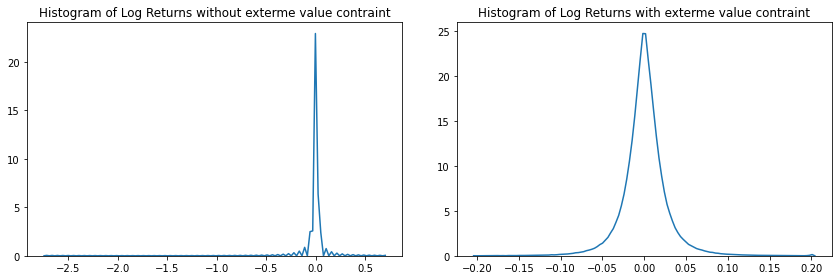

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(0)) & (ret_mat.index < datetime(2005, 1, 1) + monthdelta(0))]

sns.kdeplot(y.stack().values, ax = ax[0])
ax[0].set_title('Histogram of Log Returns without exterme value contraint')

y_new = y
for j in range(len(y.columns)):
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values >= 0.2)[0], j].values, 0.2) # A 20-nál nagyobb értékeket 20ra állítom
    y_new = y_new.replace(y.iloc[np.where(y_new.iloc[:, j].values <= -0.2)[0], j].values, -0.2) # A -20-nál kisebb értékeket -20ra állítom

sns.kdeplot(y_new.stack().values, ax = ax[1])
ax[1].set_title('Histogram of Log Returns with exterme value contraint')

plt.tight_layout()
plt.show()

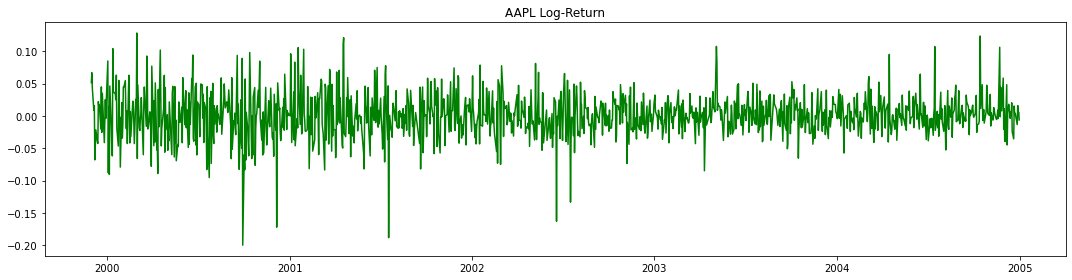

In [6]:
plt.figure(figsize = (15, 4))
plt.plot(pd.to_datetime(y.index), y_new.AAPL, 'g')
plt.title('AAPL Log-Return')
plt.tight_layout()
plt.show()

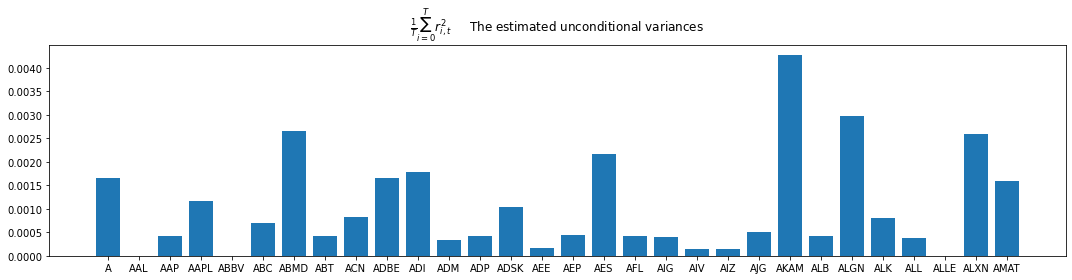

In [7]:
#Ezzel a kezdőértékkel indul meg a sigma2 számolása
plt.figure(figsize= (15,4))
plt.bar(y.columns[:30], np.nanmean(y_new ** 2, axis = 0)[:30])
plt.title(r'$\frac{1}{T} \sum_{i=0}^T r_{i,t}^2$' + '\t The estimated unconditional variances')
plt.tight_layout()
plt.show()

In [8]:
model = Panel_GARCH()

##### Az extrém értékek kiszűrése nélkül futtatott model:

In [25]:
model.fit(['01', '01'], y)

Loglikelihood:  -947.4091306876135 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  1.867219e-13        0.009200     -0.018032       0.018032
1  1.000000e+00        0.014073      0.972418       1.027582


###### Az extrém értékek korlátozásával futtatott model:

In [9]:
model.fit(['01', '01'], y_new.iloc[:, :50])

Loglikelihood:  -98.16788646193685 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.056568        0.012646      0.031783       0.081353
1    0.931369        0.011796      0.908249       0.954488


In [10]:
model.fit(['01', '01'], y_new.iloc[:, :100])

Loglikelihood:  -190.93507061367788 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  3.468953e-07        0.010267     -0.020122       0.020123
1  1.000000e+00        0.015539      0.969545       1.030455


In [11]:
model.fit(['01', '01'], y_new.iloc[:, :75])

Loglikelihood:  -146.64574260806626 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000012        0.007599     -0.014881       0.014906
1    1.000000        0.010327      0.979759       1.020241


In [12]:
model.fit(['01', '01'], y_new.iloc[:, :60])

Loglikelihood:  -113.63478189001225 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  5.739472e-08        0.007515     -0.014729       0.014730
1  1.000000e+00        0.010655      0.979117       1.020883


In [13]:
model.fit(['01', '01'], y_new.iloc[:, :55])

Loglikelihood:  -105.60049191042285 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.052854        0.012267      0.028811       0.076898
1    0.936639        0.011238      0.914614       0.958665


In [15]:
model.fit(['01', '01'], y_new.iloc[:, :58])

Loglikelihood:  -109.28936666492955 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  2.445713e-10        0.006381     -0.012506       0.012506
1  1.000000e+00        0.009348      0.981677       1.018323


##### Az első 58ra lefut, viszont az 59.-nél a paraméterek, ahogy az előző futtatásnál látszik, be crash-sel.

In [16]:
model.fit(['01', '01'], y_new.iloc[:, :57])

Loglikelihood:  -110.7038170029924 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.053370        0.012103      0.029648       0.077092
1    0.936027        0.011248      0.913981       0.958072


#### Ábrázoltam azt a részvényt amelyiknél crash-sel, hátha kiad valami használhatót

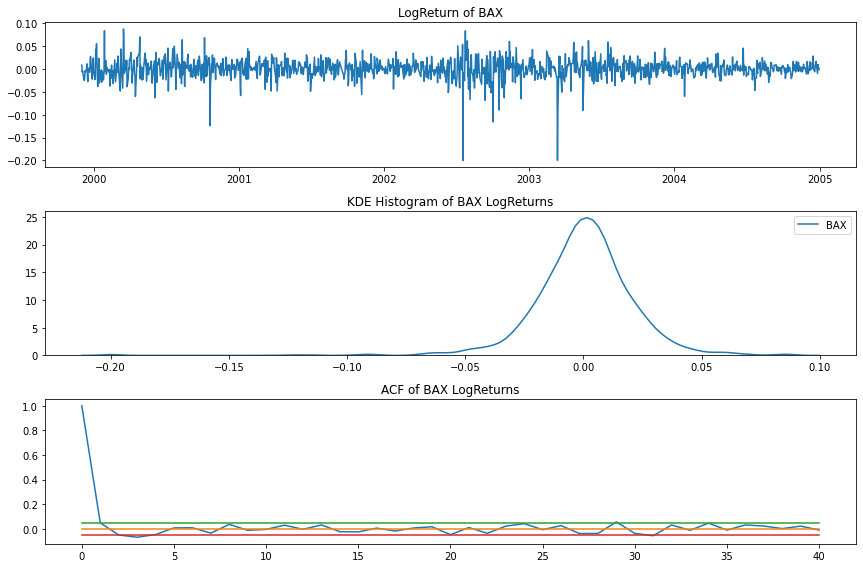

In [37]:
from statsmodels.tsa.stattools import acf
fig, ax = plt.subplots(3,1, figsize = (12,8))

sns.lineplot(data = y_new.iloc[:, 57], ax = ax[0])
ax[0].set_title('LogReturn of BAX')

sns.kdeplot(data = y_new.iloc[:, 57], ax = ax[1])
ax[1].set_title('KDE Histogram of BAX LogReturns')

sns.lineplot(data = acf(y_new.iloc[:, 57].values), ax = ax[2])
sns.lineplot(data = np.linspace(0.0, 0.0, 41), ax = ax[2])
sns.lineplot(data = np.linspace(0.05, 0.05, 41), ax = ax[2])
sns.lineplot(data = np.linspace(-0.05, -0.05, 41), ax = ax[2])
ax[2].set_title('ACF of BAX LogReturns')

plt.tight_layout()
plt.show()

#### A korrelációs mátrixot is mégnéztem, hát ha itt lesz valami.

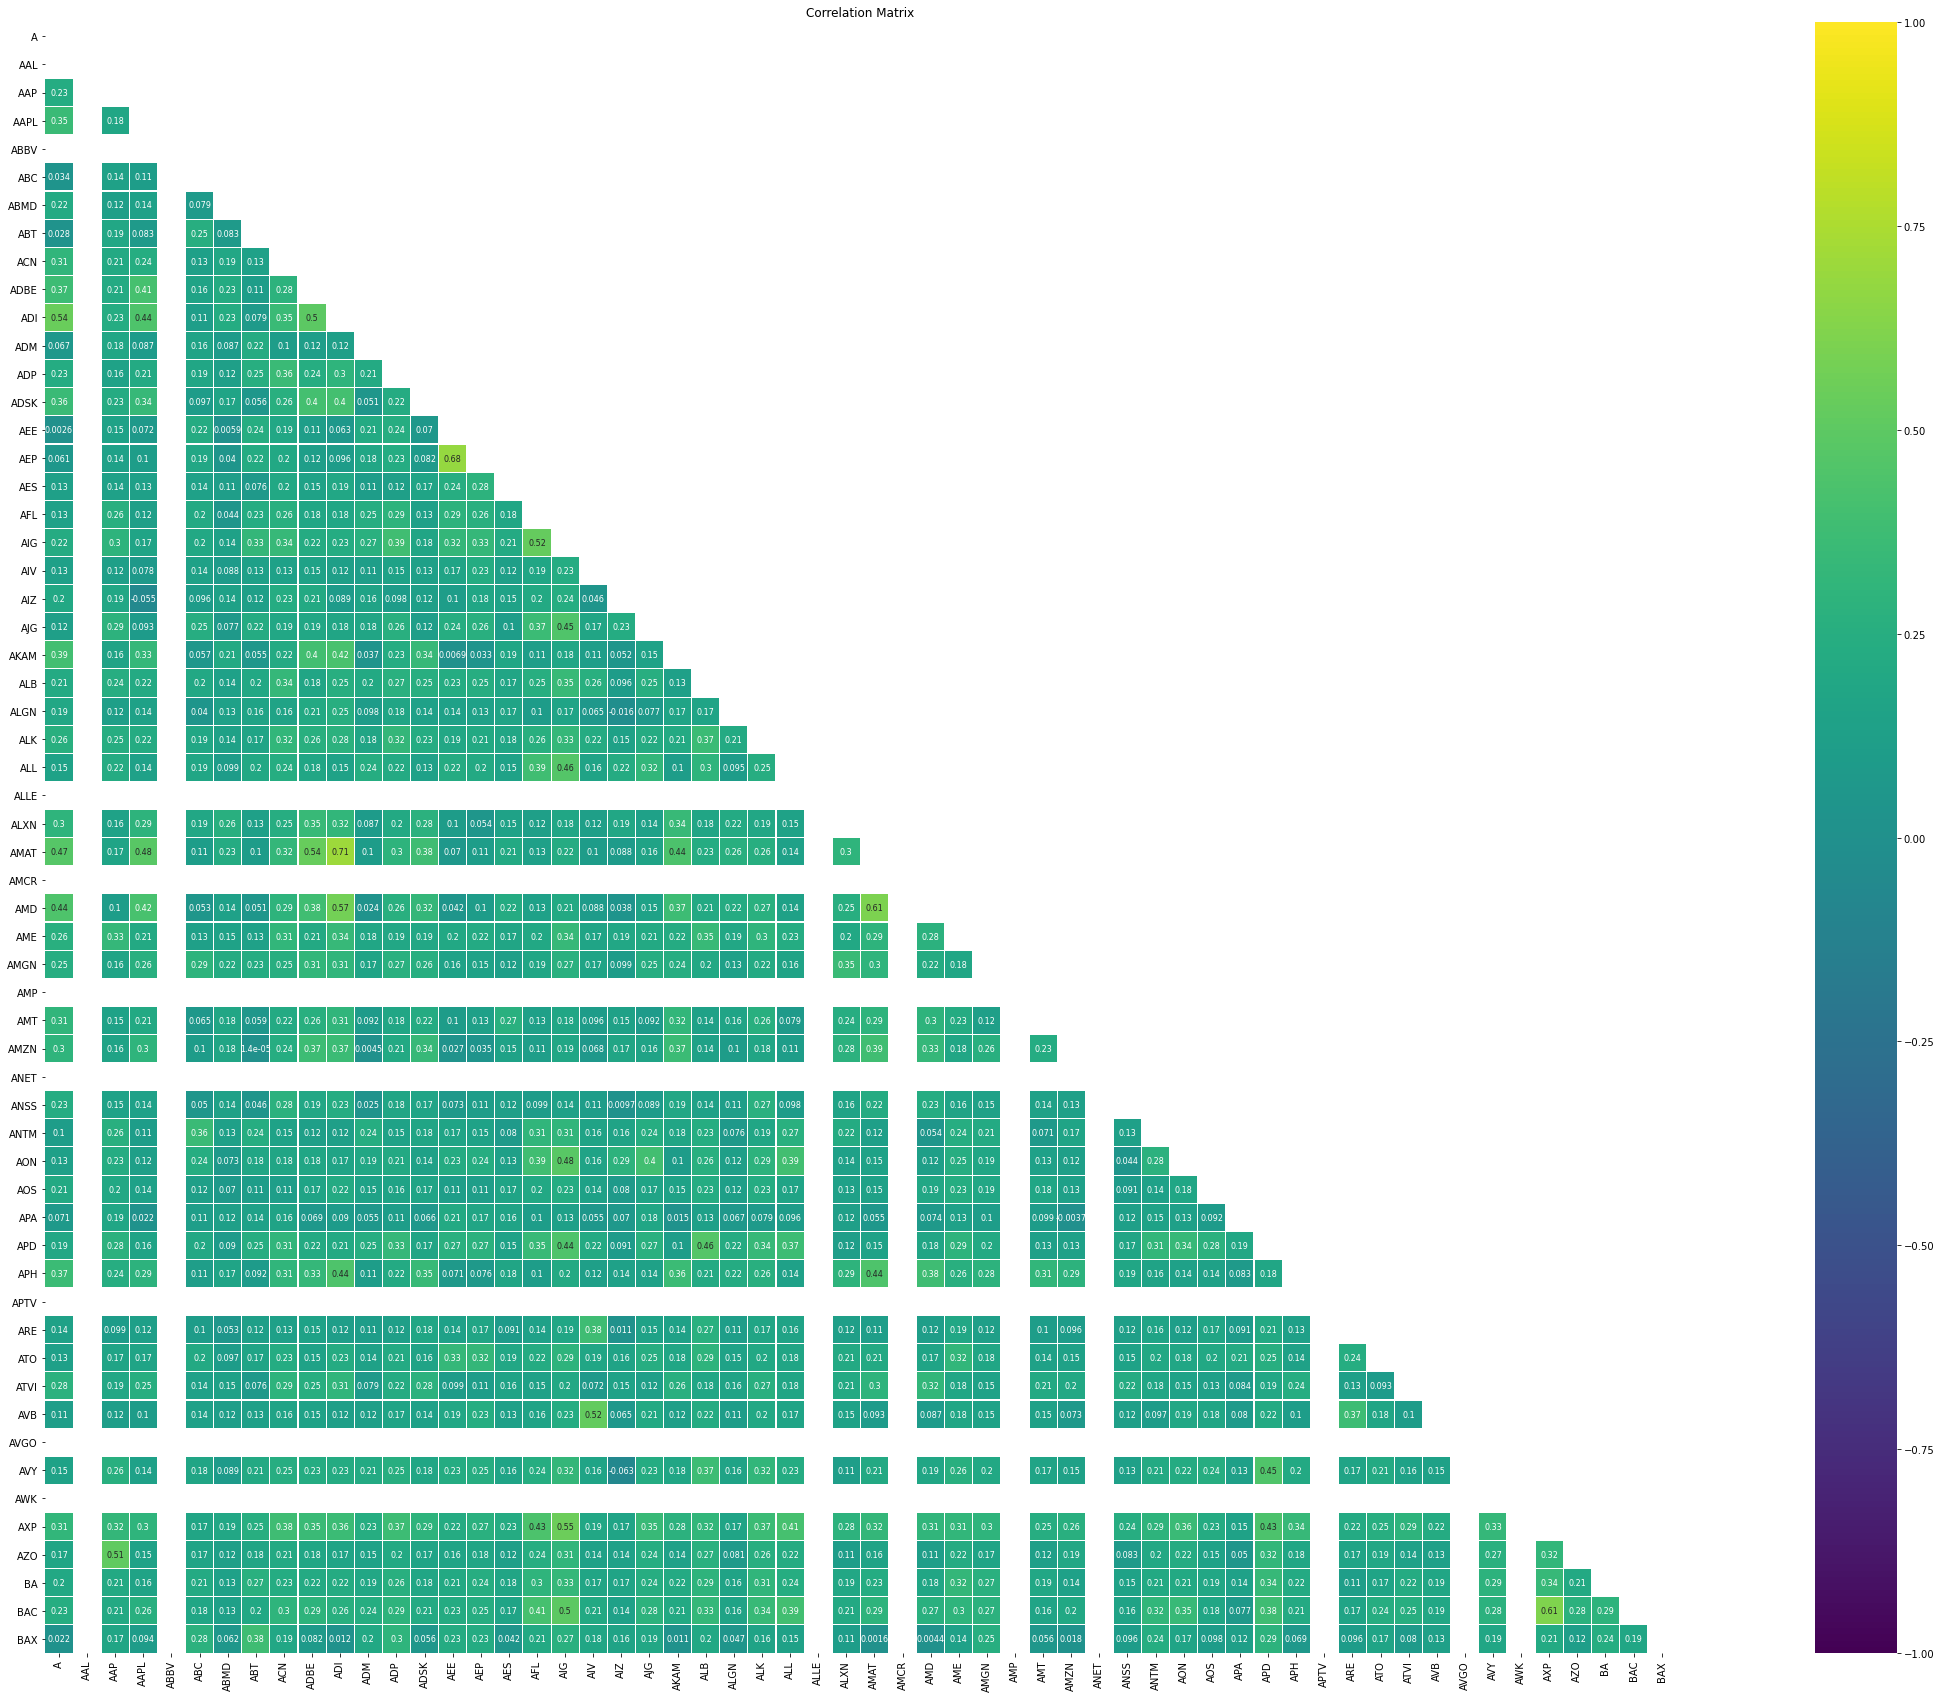

In [43]:
f, ax = plt.subplots(figsize=(50, 30))

ax = sns.heatmap(y_new.iloc[:, :58].corr(), 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True, mask = np.triu(y_new.iloc[:, :58].corr()))
ax.set_title('Correlation Matrix')
plt.show()

##### Ha 100-zal beszorozzuk akkor:

In [27]:
model.fit(['01', '01'], y_new * 100)

Loglikelihood:  955.7298460375661 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  1.419957e-09        0.005179     -0.010150       0.010150
1  1.000000e+00        0.006965      0.986348       1.013652


#### Ha kiszűrjük azt az egy oszpolot, se lesz jobb a helyzet:

In [52]:
model.fit(['01', '01'], y_new.iloc[:, np.concatenate((np.linspace(0, 57, 58), np.linspace(59, 100, 42)))])

Loglikelihood:  -189.0451356772767 

     Parameters  Standard Error  95% CI Lower  95% CI Higher
0  6.546850e-07        0.010067     -0.019731       0.019732
1  1.000000e+00        0.015217      0.970176       1.029824


## Panel GARCH with cross sectional adjustment

#### Megnéztem, hogy itt a transzfromálatlan adatokra, lefut-e ez a modell.

In [4]:
from volatility import Panel_GARCH_CSA

In [5]:
mod_csa = Panel_GARCH_CSA()

### Amint látszik, lefuttott az adatokra:

In [6]:
mod_csa.fit(['01', '01', '01'], y * 100)

Loglikelihood:  960.642322526277 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.984814        0.003064      0.978808       0.990820
1    0.099387        0.002200      0.095075       0.103699
2    0.733042        0.014086      0.705434       0.760651
